In [31]:
import numpy as np
from math import*
import matplotlib.pyplot as plt
import random
import scipy
import scipy.stats

plt.rcParams["figure.figsize"] = (8,8)

In [32]:
class CauchyBandit :
    def __init__(self, loc, scale, seed = None):
        ''' Entrées:
                - loc: un array décrivant les paramètres de localisations des lois de Cauchy décrivant les actions
                - scale: un array décrivant les paramètres d'échelle des lois de Cauchy décrivant les actions
                - seed (optionnel): un seed. 
        '''

        np.random.seed(seed=seed)
        
        self.loc = loc
        
        self.scale= scale
        
        self.ps_regrets = []

        self.locstar = max(self.loc)
        
        self.kstar = np.argmax(loc)
        
        self.gaps = self.locstar - loc

        
    def get_K(self):
        ''' Return the number of actions . '''

        K = len(self.loc)
        
        return K
        
    def play(self,action):
        ''' Accept a parameter 0 <= k < K, logs the instant pseudo - regret ,
        and return the realization of a Cauchy random variable with P(X =1)
        being the mean of the given action . '''

        #méthode de conténation append
        self.ps_regrets.append(self.gaps[action])
        
        reward = scipy.stats.cauchy.rvs(self.loc[action], self.scale[action],size=1)[0]
        
        return reward

    def get_cumulative_regret(self):
        ''' Return an array of the cumulative sum of pseudo - regret per round . '''
        return np.cumsum(self.ps_regrets)

Definition des algorithme que nous allons tester

In [33]:
def etc(bandit , T, estimator, m, discret=False):
    '''T: L'horizon
       m: Le nombre de tirage de chacune des actions dans le tour exploratoire
       discret: Pour faire un bris d'égalité ou non (nécessaire dans le cas de distributions discrètes)
       estimator: une lambda calculant l'estimation empirique '''
     
    K = bandit.get_K() #Obtention du nombre d'actions possibles.
        
    # Phase d'exploration (m tours sur chaque action)
    estimateurs = []
    for k in range(bandit.get_K()):
        m_estimateurs = []
        for i in range(m):
            m_estimateurs.append(bandit.play(k))
        estimateurs.append(estimator(m_estimateurs))

    # Calcul de l'action optimale

    ##Si la loi des bras est discrète, on doit gérer le cas où il peut y avoir bris d'égalité. 
    if(discret):
        kstar_est = np.where(estimateurs == max(estimateurs))[0]

        if (len(kstar_est) > 1):
            kstar_est = np.random.choice(kstar_est,1)[0]
    else:
        kstar_est = np.argmax(estimateurs)
            
    # Phase d'exploitation

    for t in range(m*K,T):
        r_t=bandit.play(kstar_est)

    return kstar_est

In [34]:
def epsilon_greedy(bandit, T, estimator, epsilon, seed=None):
    random = np.random.RandomState(seed)
    K = bandit.get_K()
    r = np.zeros(T)

    # Préparation d'une liste de K listes prêt à contenir les rewards pour chacune des K actions.
    R = []
    for i in range(K):
        R.append([])
    
    #Préparation d'un vecteur pour l'estimateur empirique de chaque action
    #initialisée à 0. L'estimateur empirique sera la moyenne ou la médiane
    
    estimateur = np.zeros(K) 
                                        
    #Le jeu commence
    for t in range(T):
        kstar_est = np.where(estimateur == max(estimateur))[0]
    
        #Traitement du bris d'égalité
        if (len(kstar_est) > 1): 
            kstar_est = random.choice(kstar_est,1)[0]
            
        if (np.random.rand(1) < epsilon):
            #explorer, jouer une des actions au hasard.
            action_played = random.choice(range(K),1)[0]
            r[t]=bandit.play(action_played)
            
        else:
            #exploiter, jouer l'action estimée optimale jusqu'à présent
            if(isinstance(kstar_est,np.ndarray)):
                kstar_est=kstar_est[0]
            
            action_played = kstar_est
            
            r[t] = bandit.play(action_played)
        
        #ajout du rewards dans l'historique de l'action jouée
        
        R[action_played].append(r[t])
        estimateur[action_played]=estimator(R[action_played])

In [35]:
# Algorithme Greedy-epsilon avec epsilon=1/sqrt(t)

def epsilon_greedy_rule(bandit, T, estimator, seed=None):
    '''Play the given bandit over T rounds . '''
    
    K = bandit.get_K()  #Obtention du nombre d'actions possibles.
    r = np.zeros(T)     #Préparation du vecteur de rewards, init. 0
    
    # Préparation d'une liste de K listes prêt à contenir les rewards pour chacune des K actions.
    R = []
    for i in range(K):
        R.append([])
    
    
    #Préparation d'un vecteur pour l'estimateur empirique de chaque action
    #initialisée à 0. L'estimateur empirique sera la moyenne ou la médiane
    estimateur = np.zeros(K)
    
    #Le jeu commence
    for t in range(T):
    
        epsilon = min([1,1/sqrt(t+1)]) #Ici, c'est t+1 car t commence à 0 dans Python.
            
        kstar_est = np.where(estimateur == max(estimateur))[0]
    
        #Traitement du bris d'égalité
        if (len(kstar_est) > 1): 
            kstar_est = np.random.choice(kstar_est,1)[0]
            
        if (np.random.rand(1) < epsilon):
            #explorer, jouer une des actions au hasard.
            action_played = np.random.choice(range(K),1)[0]
            r[t]=bandit.play(action_played)
            
        else:
            #exploiter, jouer l'action estimée optimale jusqu'à présent
            if(isinstance(kstar_est,np.ndarray)):
                kstar_est=kstar_est[0]
            
            action_played = kstar_est
            
            r[t] = bandit.play(action_played)
        
        #ajout du rewards dans l'historique de l'action jouée
        
        R[action_played].append(r[t])
    
        #Modifier la moyenne ou la médiane de l'action jouée
        estimateur[action_played]=estimator(R[action_played])

In [36]:
def blotzmann_softmax(bandit, T, estimator, lr, seed=None):
    random = np.random.RandomState(seed)
    K = bandit.get_K()
    r = np.zeros(T)

    # Préparation d'une liste de K listes prêt à contenir les rewards pour chacune des K actions.
    R = []
    for i in range(K):
        R.append([])
    
    #Préparation d'un vecteur pour l'estimateur empirique de chaque action
    #initialisée à 0. L'estimateur empirique sera la moyenne ou la médiane
    
    estimateur = np.zeros(K)
    num_prob = np.ones(K)
                                        
    #Le jeu commence
    for t in range(T):
        prob = num_prob / np.sum(num_prob)
        
        k_t = np.random.choice(range(K), p=prob)
        
            
        r[t] = bandit.play(k_t)
        
        #ajout du rewards dans l'historique de l'action jouée
        
        R[k_t].append(r[t])
        estimateur[k_t]=estimator(R[k_t])

        norm_est = (estimateur - estimateur.mean)/estimateur.std

        num_prob[k_t] = exp(lr * norm_est[k_t])

Definition des différentes fonctions d'estimations que nous allons tester

In [37]:
def mean_estimator(X):
    return np.mean(X)

In [38]:
def median_estimator(X):
    return np.median(X)

In [39]:
def truncated_mean_estimator(X, tmean):
    return scipy.stats.trim_mean(X, tmean)

In [40]:
def l_estimator(X):
    N = len(X)
    estimation = 0
    x_sorted = np.sort(X)

    for i in range(N):
        u = (i+1) / (N+1)
        tan_value=tan(np.pi * (u - 0.5))
        sin_value=sin(4* np.pi * (u - 0.5))
        if tan_value==0:
            coefficient=4
        else:
            coefficient=sin_value/tan_value
        
        estimation += coefficient*x_sorted[i]
    
    return estimation / N

In [41]:
def maximum_likelihood_estimator(X, tolerance=0.001, max_steps=500):
    LOG_LIKELIHOOD_DERIVATIVE = lambda x, theta: 2 * sum((x - theta) / (1 + (x - theta)**2))
    theta_estimation = np.median(X)

    first_deriv = LOG_LIKELIHOOD_DERIVATIVE(X, theta_estimation)
    for step in range(max_steps):
        if abs(first_deriv) < tolerance:
            break
        second_deriv = 2 * sum(((X - theta_estimation)**2 - 1) / (1 + (X - theta_estimation)**2)**2)
        theta_estimation = theta_estimation - first_deriv / second_deriv
        first_deriv = LOG_LIKELIHOOD_DERIVATIVE(X, theta_estimation)

    return theta_estimation

In [42]:
def chauchy_expertiment(algorithm, estimator, scale, get_location, episodes=100, steps=5000, get_seed=lambda i: None, plot_fct=None):
    cumulative_regret = []
    
    for i in range(episodes):
        bandit = CauchyBandit(loc=get_location(i), scale=scale, seed=get_seed(i))
        algorithm(bandit, T=steps, estimator=estimator, episode=i)
        cumulative_regret.append(bandit.get_cumulative_regret())
        
    mean_cumulative_regret = np.apply_along_axis(np.mean, 0, cumulative_regret)
    std_cumulative_regret = np.apply_along_axis(np.std, 0, cumulative_regret)
    
    if plot_fct is not None:
        plot_fct(mean_cumulative_regret, std_cumulative_regret)

    return mean_cumulative_regret, std_cumulative_regret

In [43]:
def plot_experiment(mean, std, label='', color=None, fill_between=False):
    plt.plot(range(len(mean)), mean, color=color, label=label)
    if fill_between:
        plt.fill_between(range(len(mean)), mean, mean + std, color=color, alpha=0.3)
    else:
        plt.plot(range(len(mean)), mean + std,color=color, linestyle='dashed')

Graphique du comportement des estimations. Test sur une Cauchy de paramètre $L=5$ et $a=1$

In [44]:
np.random.seed(87)
T=100000
loc=5
scale=1
X=scipy.stats.cauchy.rvs(loc=loc,scale=scale,size=T)
moyenne_empirique=np.zeros(T,dtype=np.float32)
for i in range(T):
    moyenne_empirique[i]=np.mean(X[:i+1])


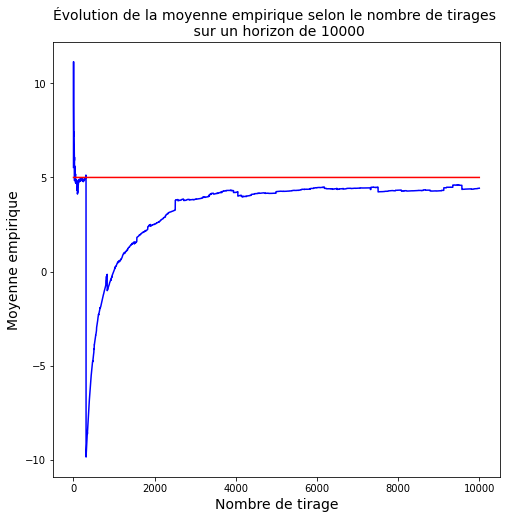

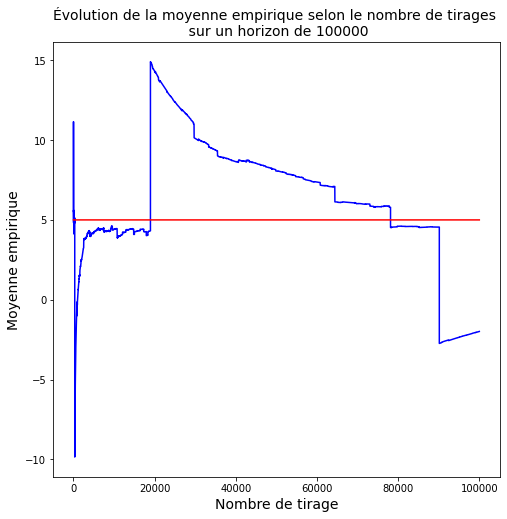

In [45]:
cible=np.repeat(loc,T)

plt.plot(range(10000),moyenne_empirique[0:10000],color='blue')
plt.plot(range(10000),cible[0:10000],label='estimateur:moyenne empirique',color='red')
plt.title('Évolution de la moyenne empirique selon le nombre de tirages \n sur un horizon de 10000',fontdict = {'fontsize' : 14})
plt.xlabel('Nombre de tirage',fontsize=14)
plt.ylabel('Moyenne empirique',fontsize=14)
plt.savefig('Presentation/graphique-moyenne-empirique-1.pdf')
plt.show()

plt.plot(range(T),moyenne_empirique,color='blue')
plt.plot(range(T),cible,label='estimateur:moyenne empirique',color='red')
plt.title('Évolution de la moyenne empirique selon le nombre de tirages \n sur un horizon de 100000',fontdict = {'fontsize' : 14})
plt.xlabel('Nombre de tirage',fontsize=14)
plt.ylabel('Moyenne empirique',fontsize=14)
plt.savefig('Presentation/graphique-moyenne-empirique-2.pdf')
plt.show()

In [46]:
np.random.seed(42)
#np.random.seed(87) pour voir comportement étrange de MLE.
T=1000
loc=5
scale=1

X=scipy.stats.cauchy.rvs(loc=loc,scale=scale,size=T)

moyenne_empirique=np.zeros(T,dtype=np.float32)
moyenne_empirique_tronquee_0_38=np.zeros(T,dtype=np.float32)
mediane_empirique=np.zeros(T,dtype=np.float32)
L_estimat_empirique=np.zeros(T,dtype=np.float32)
mle=np.zeros(T,dtype=np.float32)

for i in range(T):
    moyenne_empirique[i]=np.mean(X[:i+1])
    moyenne_empirique_tronquee_0_38[i]=truncated_mean_estimator(X[:i+1],0.38)
    mediane_empirique[i]=np.median(X[:i+1])
    L_estimat_empirique[i]=l_estimator(X[:i+1])
    #mle[i]=maximum_likelihood_estimator(X[:i+1], tolerance=0.001, max_steps=500)
    mle[i]=maximum_likelihood_estimator(X[:i+1], tolerance=0.0001, max_steps=5000)

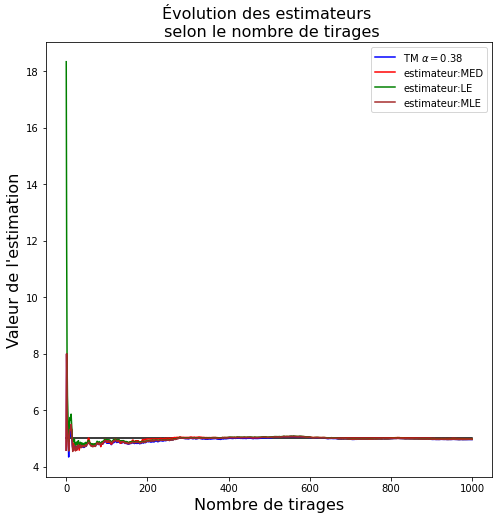

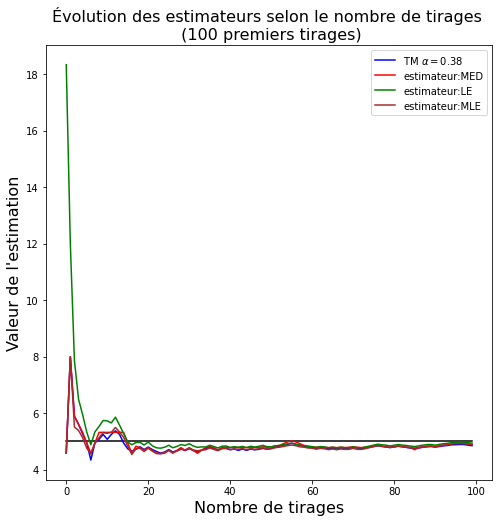

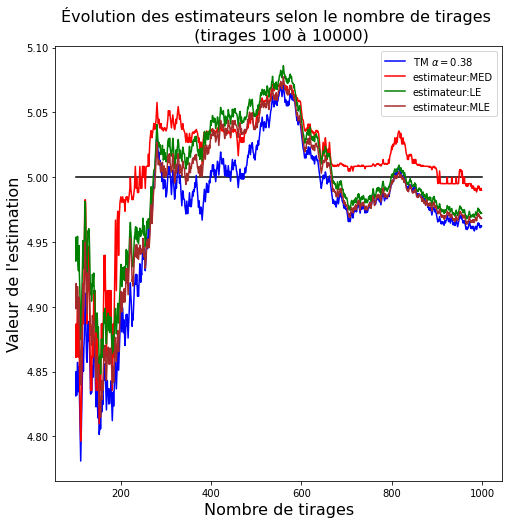

In [47]:
cible=np.repeat(5,T)
plt.plot(range(T),cible,color='black')
#plt.plot(range(T),moyenne_empirique,label='estimateur:moyenne empirique',color='blue')
plt.plot(range(T),moyenne_empirique_tronquee_0_38,label=r'TM $\alpha=0.38$',color='blue')
plt.plot(range(T),mediane_empirique,label='estimateur:MED',color='red')
plt.plot(range(T),L_estimat_empirique,label='estimateur:LE',color='green')
plt.plot(range(T),mle,label='estimateur:MLE',color='brown')
plt.title('Évolution des estimateurs \n selon le nombre de tirages',fontdict = {'fontsize' : 16})
plt.ylabel("Valeur de l'estimation",fontsize=16)
plt.xlabel('Nombre de tirages',fontsize=16)
plt.legend()
plt.savefig('Presentation/Est-1000.pdf')
plt.show()


plt.plot(range(100),cible[0:100],color='black')
plt.plot(range(100),moyenne_empirique_tronquee_0_38[0:100],label=r'TM $\alpha=0.38$',color='blue')
plt.plot(range(100),mediane_empirique[0:100],label='estimateur:MED',color='red')
plt.plot(range(100),L_estimat_empirique[0:100],label='estimateur:LE',color='green')
plt.plot(range(100),mle[0:100],label='estimateur:MLE',color='brown')
plt.title('Évolution des estimateurs selon le nombre de tirages \n (100 premiers tirages)',fontdict = {'fontsize' : 16})
plt.ylabel("Valeur de l'estimation",fontsize=16)
plt.xlabel('Nombre de tirages',fontsize=16)
plt.legend()
plt.savefig('Presentation/Est-100.pdf')
plt.show()

plt.plot(range(100,T),cible[100:T],color='black')
plt.plot(range(100,T),moyenne_empirique_tronquee_0_38[100:T],label=r'TM $\alpha=0.38$',color='blue')
plt.plot(range(100,T),mediane_empirique[100:T],label='estimateur:MED',color='red')
plt.plot(range(100,T),L_estimat_empirique[100:T],label='estimateur:LE',color='green')
plt.plot(range(100,T),mle[100:T],label='estimateur:MLE',color='brown')
plt.title('Évolution des estimateurs selon le nombre de tirages \n (tirages 100 à 10000)',fontdict = {'fontsize' : 16})
plt.ylabel("Valeur de l'estimation",fontsize=16)
plt.xlabel('Nombre de tirages',fontsize=16)
plt.savefig('Presentation/Est-100-1000.pdf')
plt.legend()
plt.show()

In [48]:
cible[100:]

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [49]:
np.random.seed(57)
T=10000
loc=5
scale=1

X=scipy.stats.cauchy.rvs(loc=loc,scale=scale,size=T)

moyenne_empirique_tronquee_0_45=np.zeros(T,dtype=np.float32)
moyenne_empirique_tronquee_0_38=np.zeros(T,dtype=np.float32)
moyenne_empirique_tronquee_0_2=np.zeros(T,dtype=np.float32)
moyenne_empirique_tronquee_0_1=np.zeros(T,dtype=np.float32)
#moyenne_empirique_tronquee_0_05=np.zeros(T,dtype=np.float32)

for i in range(T):
    moyenne_empirique_tronquee_0_45[i]=truncated_mean_estimator(X[:i+1],0.45)
    moyenne_empirique_tronquee_0_38[i]=truncated_mean_estimator(X[:i+1],0.38)
    moyenne_empirique_tronquee_0_2[i]=truncated_mean_estimator(X[:i+1],0.2)
    moyenne_empirique_tronquee_0_1[i]=truncated_mean_estimator(X[:i+1],0.1)
   # moyenne_empirique_tronquee_0_05[i]=truncated_mean_estimator(X[:i+1],0.05)

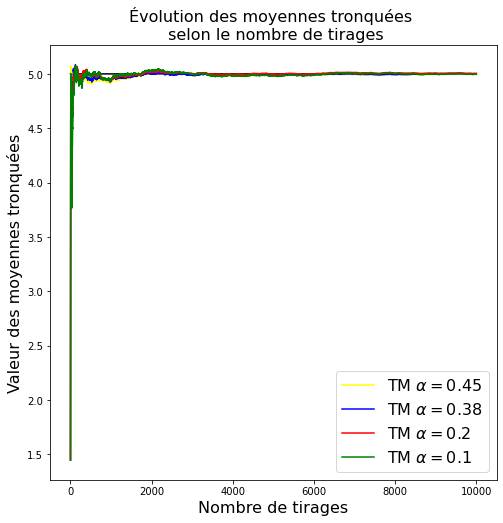

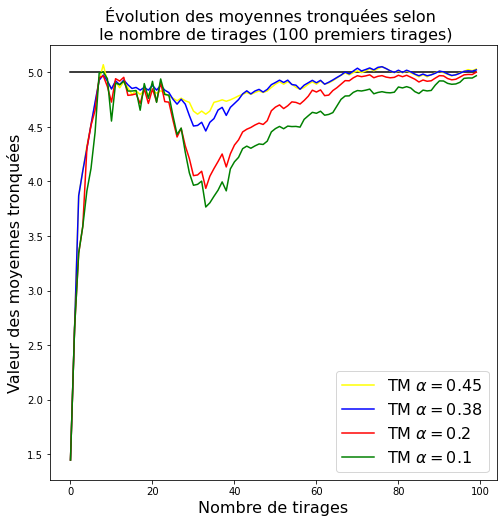

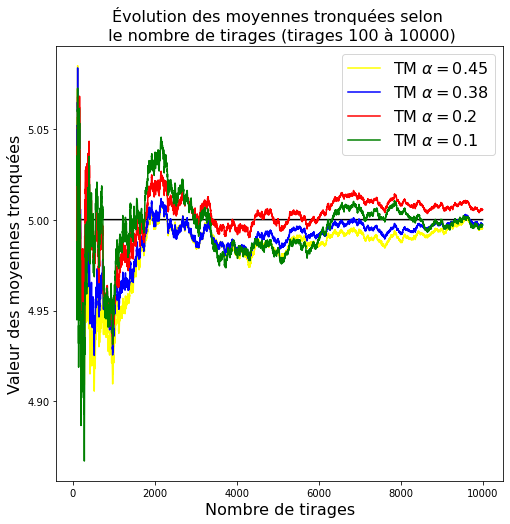

In [50]:
cible=np.repeat(5,T)

plt.plot(range(T),cible,color='black')
#plt.plot(range(T),moyenne_empirique,label='estimateur:moyenne empirique',color='blue')
plt.plot(range(T),moyenne_empirique_tronquee_0_45,label=r'TM $\alpha=0.45$',color='yellow')
plt.plot(range(T),moyenne_empirique_tronquee_0_38,label=r'TM $\alpha=0.38$',color='blue')
plt.plot(range(T),moyenne_empirique_tronquee_0_2,label=r'TM $\alpha=0.2$',color='red')
plt.plot(range(T),moyenne_empirique_tronquee_0_1,label=r'TM $\alpha=0.1$',color='green')
#plt.plot(range(T),moyenne_empirique_tronquee_0_05,label='estimateur:moyenne tronquée 0.05',color='brown')
plt.title('Évolution des moyennes tronquées \n selon le nombre de tirages',fontdict = {'fontsize' : 16})
plt.ylabel('Valeur des moyennes tronquées',fontsize=16)
plt.xlabel('Nombre de tirages',fontsize=16)
plt.legend(fontsize=16)
plt.savefig('Presentation/mt-10000.pdf')
plt.show()

plt.plot(range(100),cible[0:100],color='black')
#plt.plot(range(T),moyenne_empirique,label='estimateur:moyenne empirique',color='blue')
plt.plot(range(100),moyenne_empirique_tronquee_0_45[0:100],label=r'TM $\alpha=0.45$',color='yellow')
plt.plot(range(100),moyenne_empirique_tronquee_0_38[0:100],label=r'TM $\alpha=0.38$',color='blue')
plt.plot(range(100),moyenne_empirique_tronquee_0_2[0:100],label=r'TM $\alpha=0.2$',color='red')
plt.plot(range(100),moyenne_empirique_tronquee_0_1[0:100],label=r'TM $\alpha=0.1$',color='green')
#plt.plot(range(T),moyenne_empirique_tronquee_0_05,label='estimateur:moyenne tronquée 0.05',color='brown')
plt.title('Évolution des moyennes tronquées selon \n le nombre de tirages (100 premiers tirages)',fontdict = {'fontsize' : 16})
plt.xlabel('Nombre de tirages',fontsize=16)
plt.ylabel('Valeur des moyennes tronquées',fontsize=16)
plt.legend(fontsize=16)
plt.savefig('Presentation/mt-100.pdf')
plt.show()

plt.plot(range(100,T),cible[100:T],color='black')
plt.plot(range(100,T),moyenne_empirique_tronquee_0_45[100:T],label=r'TM $\alpha=0.45$',color='yellow')
plt.plot(range(100,T),moyenne_empirique_tronquee_0_38[100:T],label=r'TM $\alpha=0.38$',color='blue')
plt.plot(range(100,T),moyenne_empirique_tronquee_0_2[100:T],label=r'TM $\alpha=0.2$',color='red')
plt.plot(range(100,T),moyenne_empirique_tronquee_0_1[100:T],label=r'TM $\alpha=0.1$',color='green')
#plt.plot(range(100,T),moyenne_empirique_tronquee_0_05[100:T],label='estimateur:moyenne tronquée 0.05',color='brown')
plt.title('Évolution des moyennes tronquées selon \n le nombre de tirages (tirages 100 à 10000)',fontdict = {'fontsize' : 16})
plt.ylabel('Valeur des moyennes tronquées',fontsize=16)
plt.xlabel('Nombre de tirages',fontsize=16)
plt.legend(fontsize=16)
plt.savefig('Presentation/mt-100-10000.pdf')
plt.show()


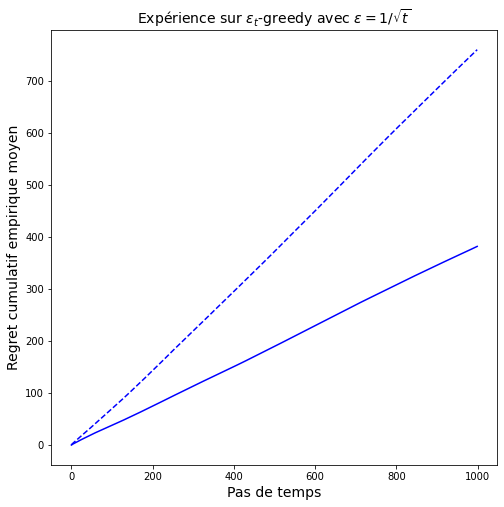

In [51]:
#Expérience pour montrer l'échec d'epsilon_greedy et epsilon_greedy_rule.

N = 200
T = 1000

SEEDS = list(range(N, N*2))

EPSILON = 0.1

epsilon_greedy_rule_wrapper = lambda *args, episode, **kargs: epsilon_greedy_rule(*args, **kargs, seed=SEEDS[episode])

epsilon_greedy_wrapper = lambda *args, episode, **kargs: epsilon_greedy(*args, **kargs, epsilon=EPSILON, seed=SEEDS[episode])

#loc=np.random.rand(N, 2)

loc=np.array([[5,6],]*N)

scale=np.array([1,1])

chauchy_expertiment(
    epsilon_greedy_rule_wrapper,
    mean_estimator, 
    scale,
    get_location=lambda i: loc[i],
    episodes=N, 
    steps=T,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="blue",
                                                   label=r'$\epsilon_t$-greedy')
)

#chauchy_expertiment(
#    epsilon_greedy_wrapper,
#    mean_estimator, 
#    scale,
#    get_location=lambda i: loc[i],
#    episodes=N, 
#    steps=T,
#    plot_fct=lambda mean, std: plot_experiment(mean, std, color="red",
#                                                   label=r'$\epsilon$-greedy'))
#)

#Graphique pour l'expérience précédente
#plt.legend(fontsize=14)
plt.title(r"Expérience sur $\epsilon_t$-greedy avec $\epsilon=1/\sqrt{t}$",fontsize=14)
plt.xlabel('Pas de temps',fontsize=14)
plt.ylabel('Regret cumulatif empirique moyen',fontsize=14)
plt.savefig('Presentation/contre-exemple-epsilon-greedy.pdf')



Text(0, 0.5, 'regret cumulatif empirique moyen')

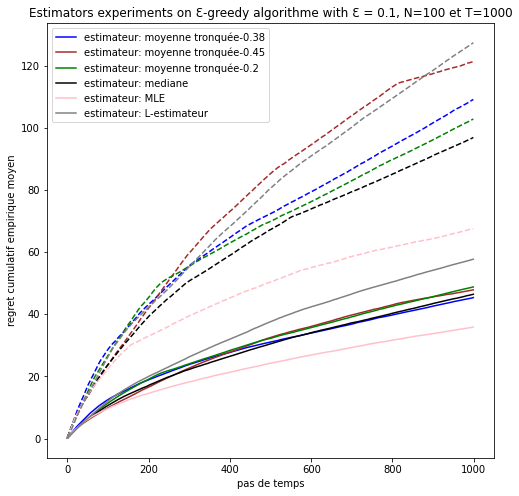

In [52]:
#Expérience pour trouver le bon copromis au niveau du tronquage.

N = 100
T = 1000
TRIM_MEAN_1 = 0.38
TRIM_MEAN_2 = 0.45
TRIM_MEAN_3 = 0.3
TRIM_MEAN_4 = 0.2
TRIM_MEAN_5 = 0.1
TRIM_MEAN_6 = 0.05

MAX_LIKELIHOOD_TOLERANCE = 0.001

SEEDS = list(range(N, N*2))

EPSILON = 0.1

epsilon_greedy_wrapper = lambda *args, episode, **kargs: epsilon_greedy(*args, **kargs, epsilon=EPSILON, seed=SEEDS[episode])

loc=np.random.rand(N, 2)
#loc=np.array([[2,10],]*N)

scale=np.array([1,1])

chauchy_expertiment(
    epsilon_greedy_wrapper,
    lambda X : truncated_mean_estimator(X, TRIM_MEAN_1), 
    scale,
    get_location=lambda i: loc[i],
    episodes=N, 
    steps=T,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="blue",
                                                   label='estimateur: moyenne tronquée-{}'.format(TRIM_MEAN_1))
)

chauchy_expertiment(
    epsilon_greedy_wrapper,
    lambda X : truncated_mean_estimator(X, TRIM_MEAN_2), 
    scale,
    get_location=lambda i: loc[i],
    episodes=N, 
    steps=T,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="brown",
                                                   label='estimateur: moyenne tronquée-{}'.format(TRIM_MEAN_2))
)

#chauchy_expertiment(
#    epsilon_greedy_wrapper,
#    lambda X : truncated_mean_estimator(X, TRIM_MEAN_3), 
#    scale,
#    get_location=lambda i: loc[i],
#    episodes=N, 
#    steps=T,
#    plot_fct=lambda mean, std: plot_experiment(mean, std, color="orange",
#                                                  label='estimateur: moyenne tronquée-{}'.format(TRIM_MEAN_3))
#)

chauchy_expertiment(
    epsilon_greedy_wrapper,
    lambda X : truncated_mean_estimator(X, TRIM_MEAN_4), 
    scale,
    get_location=lambda i: loc[i],
    episodes=N, 
    steps=T,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="green", 
                                                  label='estimateur: moyenne tronquée-{}'.format(TRIM_MEAN_4))
)

#chauchy_expertiment(
#    epsilon_greedy_wrapper,
#    lambda X : truncated_mean_estimator(X, TRIM_MEAN_5), 
#    scale,
#    get_location=lambda i: loc[i],
#    episodes=N, 
#    steps=T,
#    plot_fct=lambda mean, std: plot_experiment(mean, std, color="yellow",
#                                                  label='estimateur: moyenne tronquée-{}'.format(TRIM_MEAN_5))
#)

#chauchy_expertiment(
#    epsilon_greedy_wrapper,
#    lambda X : truncated_mean_estimator(X, TRIM_MEAN_6), 
#    scale,
#    get_location=lambda i: loc[i],
#    episodes=N, 
#    steps=T,
#    plot_fct=lambda mean, std: plot_experiment(mean, std, color="pink",
#                                                  label='estimateur: moyenne tronquée-{}'.format(TRIM_MEAN_6))
#)

chauchy_expertiment(
    epsilon_greedy_wrapper,
    median_estimator, 
    scale,
    get_location=lambda i: loc[i],
    episodes=N, 
    steps=T,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="black",
                                                  label='estimateur: mediane')
)

chauchy_expertiment(
    epsilon_greedy_wrapper,
    lambda X : maximum_likelihood_estimator(X, tolerance=MAX_LIKELIHOOD_TOLERANCE), 
    scale,
    get_location=lambda i: loc[i],
    episodes=N, 
    steps=T,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="pink",
                                                  label='estimateur: MLE')
)

chauchy_expertiment(
    epsilon_greedy_wrapper,
    l_estimator, 
    scale,
    get_location=lambda i: loc[i],
    episodes=N, 
    steps=T,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="gray",
                                                  label='estimateur: L-estimateur')
)

plt.legend()
plt.title(f"Estimators experiments on Ɛ-greedy algorithme with Ɛ = {EPSILON}, N={N} et T={T}")
plt.xlabel('pas de temps')
plt.ylabel('regret cumulatif empirique moyen')


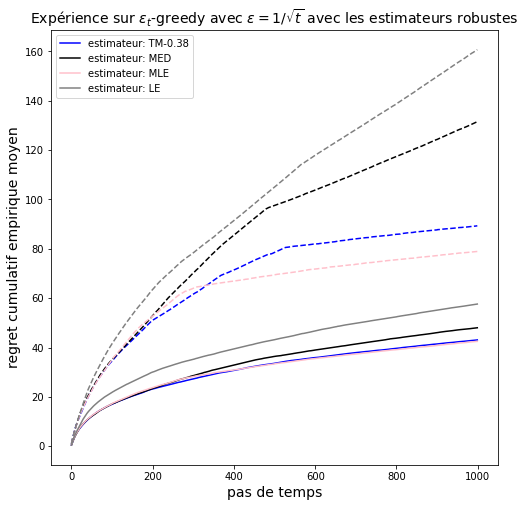

In [53]:
####Expérience sur epsilon greedy rule avec 2 bras fixes#######

N = 200
T = 1000
TRIM_MEAN_1 = 0.38
#TRIM_MEAN_2 = 0.45
#TRIM_MEAN_3 = 0.3
#TRIM_MEAN_4 = 0.2
#TRIM_MEAN_5 = 0.1
#TRIM_MEAN_6 = 0.05

MAX_LIKELIHOOD_TOLERANCE = 0.001

SEEDS = list(range(N, N*2))

EPSILON = 0.1

epsilon_greedy_rule_wrapper = lambda *args, episode, **kargs: epsilon_greedy_rule(*args, **kargs, seed=SEEDS[episode])

#loc=np.random.rand(N, 2)
loc=np.array([[5,6],]*N)

scale=np.array([1,1])

chauchy_expertiment(
    epsilon_greedy_rule_wrapper,
    lambda X : truncated_mean_estimator(X, TRIM_MEAN_1), 
    scale,
    get_location=lambda i: loc[i],
    episodes=N, 
    steps=T,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="blue",
                                                   label='estimateur: TM-{}'.format(TRIM_MEAN_1))
)

#chauchy_expertiment(
#    epsilon_greedy_rule_wrapper,
#    lambda X : truncated_mean_estimator(X, TRIM_MEAN_2), 
#    scale,
#    get_location=lambda i: loc[i],
#    episodes=N, 
#    steps=T,
#    plot_fct=lambda mean, std: plot_experiment(mean, std, color="brown",
#                                                   label='estimateur: moyenne tronquée-{}'.format(TRIM_MEAN_2))
#)


#chauchy_expertiment(
#    epsilon_greedy_rule_wrapper,
#    lambda X : truncated_mean_estimator(X, TRIM_MEAN_4), 
#    scale,
#    get_location=lambda i: loc[i],
#    episodes=N, 
#    steps=T,
#    plot_fct=lambda mean, std: plot_experiment(mean, std, color="green", 
#                                                  label='estimateur: moyenne tronquée-{}'.format(TRIM_MEAN_4))
#)

chauchy_expertiment(
    epsilon_greedy_rule_wrapper,
    median_estimator, 
    scale,
    get_location=lambda i: loc[i],
    episodes=N, 
    steps=T,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="black",
                                                  label='estimateur: MED')
)

chauchy_expertiment(
    epsilon_greedy_rule_wrapper,
    lambda X : maximum_likelihood_estimator(X, tolerance=MAX_LIKELIHOOD_TOLERANCE), 
    scale,
    get_location=lambda i: loc[i],
    episodes=N, 
    steps=T,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="pink",
                                                  label='estimateur: MLE')
)

chauchy_expertiment(
    epsilon_greedy_rule_wrapper,
    l_estimator, 
    scale,
    get_location=lambda i: loc[i],
    episodes=N, 
    steps=T,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="gray",
                                                  label='estimateur: LE')
)

plt.legend()
plt.title(r"Expérience sur $\epsilon_t$-greedy avec $\epsilon=1/\sqrt{t}$ avec les estimateurs robustes",fontsize=14)
plt.xlabel('pas de temps',fontsize=14)
plt.ylabel('regret cumulatif empirique moyen',fontsize=14)
plt.savefig('Presentation/experience-epsilon-t-greedy.pdf')

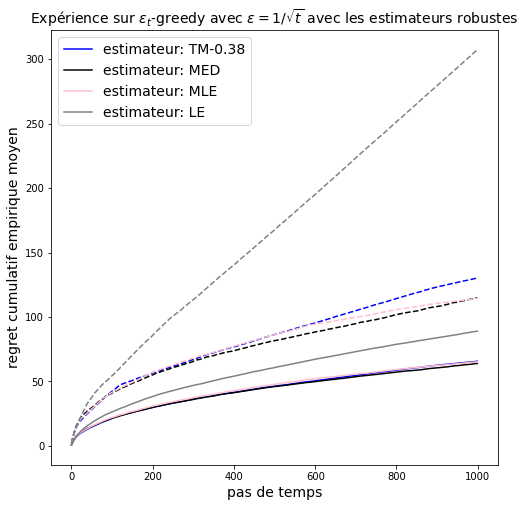

In [54]:
####Expérience sur epsilon greedy rule avec 2 bras de localisation dans l'intervalle [0,5]#######

N = 200
T = 1000
TRIM_MEAN_1 = 0.38
#TRIM_MEAN_2 = 0.45
#TRIM_MEAN_3 = 0.3
#TRIM_MEAN_4 = 0.2
#TRIM_MEAN_5 = 0.1
#TRIM_MEAN_6 = 0.05

MAX_LIKELIHOOD_TOLERANCE = 0.001

SEEDS = list(range(N, N*2))

EPSILON = 0.1

epsilon_greedy_rule_wrapper = lambda *args, episode, **kargs: epsilon_greedy_rule(*args, **kargs, seed=SEEDS[episode])

loc=5*np.random.rand(N, 2)
#loc=np.array([[5,6],]*N)

scale=np.array([1,1])

chauchy_expertiment(
    epsilon_greedy_rule_wrapper,
    lambda X : truncated_mean_estimator(X, TRIM_MEAN_1), 
    scale,
    get_location=lambda i: loc[i],
    episodes=N, 
    steps=T,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="blue",
                                                   label='estimateur: TM-{}'.format(TRIM_MEAN_1))
)

#chauchy_expertiment(
#    epsilon_greedy_rule_wrapper,
#    lambda X : truncated_mean_estimator(X, TRIM_MEAN_2), 
#    scale,
#    get_location=lambda i: loc[i],
#    episodes=N, 
#    steps=T,
#    plot_fct=lambda mean, std: plot_experiment(mean, std, color="brown",
#                                                   label='estimateur: moyenne tronquée-{}'.format(TRIM_MEAN_2))
#)


#chauchy_expertiment(
#    epsilon_greedy_rule_wrapper,
#    lambda X : truncated_mean_estimator(X, TRIM_MEAN_4), 
#    scale,
#    get_location=lambda i: loc[i],
#    episodes=N, 
#    steps=T,
#    plot_fct=lambda mean, std: plot_experiment(mean, std, color="green", 
#                                                  label='estimateur: moyenne tronquée-{}'.format(TRIM_MEAN_4))
#)

chauchy_expertiment(
    epsilon_greedy_rule_wrapper,
    median_estimator, 
    scale,
    get_location=lambda i: loc[i],
    episodes=N, 
    steps=T,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="black",
                                                  label='estimateur: MED')
)

chauchy_expertiment(
    epsilon_greedy_rule_wrapper,
    lambda X : maximum_likelihood_estimator(X, tolerance=MAX_LIKELIHOOD_TOLERANCE), 
    scale,
    get_location=lambda i: loc[i],
    episodes=N, 
    steps=T,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="pink",
                                                  label='estimateur: MLE')
)

chauchy_expertiment(
    epsilon_greedy_rule_wrapper,
    l_estimator, 
    scale,
    get_location=lambda i: loc[i],
    episodes=N, 
    steps=T,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="gray",
                                                  label='estimateur: LE')
)

plt.legend(fontsize=14)
plt.title(r"Expérience sur $\epsilon_t$-greedy avec $\epsilon=1/\sqrt{t}$ avec les estimateurs robustes",fontsize=14)
plt.xlabel('pas de temps',fontsize=14)
plt.ylabel('regret cumulatif empirique moyen',fontsize=14)
plt.savefig('Presentation/experience-epsilon-t-greedy-2.pdf')

In [55]:
np.array([[2,10],]*N)
np.random.rand(N, 2)

array([[0.97477556, 0.06505926],
       [0.79841952, 0.36092209],
       [0.9902548 , 0.51379404],
       [0.88333782, 0.18626523],
       [0.61397498, 0.55438663],
       [0.96600669, 0.38747223],
       [0.22821777, 0.61752197],
       [0.24733281, 0.8962295 ],
       [0.60180057, 0.77032899],
       [0.54756938, 0.42529888],
       [0.53971415, 0.08842915],
       [0.06771383, 0.81763057],
       [0.98094483, 0.16356494],
       [0.62033854, 0.74650263],
       [0.29312684, 0.39075273],
       [0.29318522, 0.47738652],
       [0.54401035, 0.72163207],
       [0.1091949 , 0.51543016],
       [0.19851428, 0.16505486],
       [0.94211482, 0.01082456],
       [0.10661941, 0.40680408],
       [0.21123028, 0.8897134 ],
       [0.63144538, 0.04587314],
       [0.68244773, 0.31002967],
       [0.25122558, 0.2269551 ],
       [0.46197335, 0.2913168 ],
       [0.66044961, 0.77303269],
       [0.56011603, 0.04764014],
       [0.40416221, 0.1272673 ],
       [0.24608679, 0.99902585],
       [0.

In [56]:
print(scipy.stats.cauchy.rvs(7, 3,size=1))
print(scipy.stats.cauchy.rvs(2, 1,size=1)[0])

[-3.44231336]
1.7702076582145234


In [57]:
K=np.array([1,3,2,4,5,4,3,5,6,7,7,7,8,7,9,10,87,110])
print(K)
print(np.sort(K))
truncated_mean_estimator(K,0.49)

[  1   3   2   4   5   4   3   5   6   7   7   7   8   7   9  10  87 110]
[  1   2   3   3   4   4   5   5   6   7   7   7   7   8   9  10  87 110]


6.5

Text(0.5, 1.0, 'Estimators experiments on ETC algorithme with m = 20')

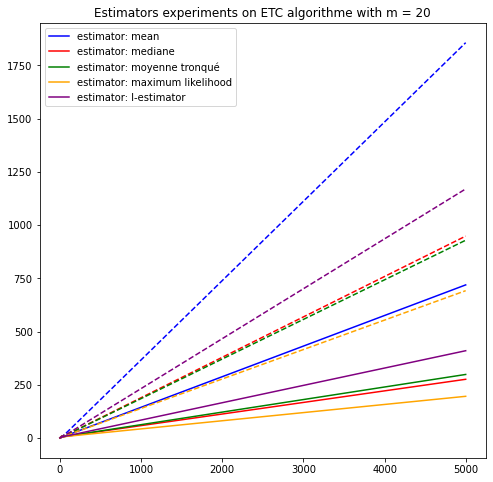

In [58]:
N = 50
T = 5000
TRIM_MEAN = 0.38
MAX_LIKELIHOOD_TOLERANCE = 0.001

m = 20

etc_wrapper = lambda *args, episode, **kargs: etc(*args, **kargs, m=m, discret=False)

loc=loc=np.random.rand(N, 2)
scale=np.array([1,1])

chauchy_expertiment(
    etc_wrapper,
    mean_estimator, 
    scale,
    get_location=lambda i: loc[i],
    episodes=N, 
    steps=T,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="blue", label='estimator: mean')
)

chauchy_expertiment(
    etc_wrapper,
    median_estimator, 
    scale,
    get_location=lambda i: loc[i],
    episodes=N, 
    steps=T,
    get_seed=lambda i: i,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="red", label='estimator: mediane')
)

chauchy_expertiment(
    etc_wrapper,
    lambda X : truncated_mean_estimator(X, TRIM_MEAN), 
    scale,
    get_location=lambda i: loc[i],
    episodes=N, 
    steps=T,
    get_seed=lambda i: i,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="green", label='estimator: moyenne tronqué')
)

chauchy_expertiment(
    etc_wrapper,
    lambda X : maximum_likelihood_estimator(X, tolerance=MAX_LIKELIHOOD_TOLERANCE), 
    scale,
    get_location=lambda i: loc[i],
    episodes=N,
    steps=T,
    get_seed=lambda i: i,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="orange", label='estimator: maximum likelihood')
)

chauchy_expertiment(
    etc_wrapper,
    l_estimator, 
    scale,
    get_location=lambda i: loc[i],
    episodes=N,
    steps=T,
    get_seed=lambda i: i,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="purple", label='estimator: l-estimator')
)

plt.legend()
plt.title(f"Estimators experiments on ETC algorithme with m = {m}")

In [61]:
#Expérience sur Boltzmann/Softmax

N = 200
T = 10000
TRIM_MEAN = 0.38
MAX_LIKELIHOOD_TOLERANCE = 0.001

SEEDS = list(range(N, N*2))

EPSILON = 0.1

epsilon_greedy_wrapper = lambda *args, episode, **kargs: epsilon_greedy(*args, **kargs, epsilon=EPSILON, seed=SEEDS[episode])

loc=np.random.rand(N, 2)
scale=np.array([1,1])

#chauchy_expertiment(
#    epsilon_greedy_wrapper,
#    mean_estimator, 
#    scale,
#    get_location=lambda i: loc[i],
#    episodes=N, 
#    steps=T,
#    plot_fct=lambda mean, std: plot_experiment(mean, std, color="blue", label='estimator: mean')
#)

chauchy_expertiment(
    epsilon_greedy_wrapper,
    median_estimator, 
    scale,
    get_location=lambda i: loc[i],
    episodes=N, 
    steps=T,
    get_seed=lambda i: i,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="red", label='estimator: mediane')
)

chauchy_expertiment(
    epsilon_greedy_wrapper,
    lambda X : truncated_mean_estimator(X, TRIM_MEAN), 
    scale,
    get_location=lambda i: loc[i],
    episodes=N, 
    steps=T,
    get_seed=lambda i: i,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="green", label='estimator: moyenne tronqué')
)

chauchy_expertiment(
    epsilon_greedy_wrapper,
    lambda X : maximum_likelihood_estimator(X, tolerance=MAX_LIKELIHOOD_TOLERANCE), 
    scale,
    get_location=lambda i: loc[i],
    episodes=N,
    steps=T,
    get_seed=lambda i: i,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="orange", label='estimator: maximum likelihood')
)

chauchy_expertiment(
    epsilon_greedy_wrapper,
    l_estimator,
    scale,
    get_location=lambda i: loc[i],
    episodes=N,
    steps=T,
    get_seed=lambda i: i,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="purple", label='estimator: l-estimator')
)

plt.legend()
plt.title(f"Estimators experiments on Ɛ-greedy algorithme with Ɛ = {EPSILON}")

KeyboardInterrupt: 

In [ ]:
N = 200
T = 10000
TRIM_MEAN = 0.38
MAX_LIKELIHOOD_TOLERANCE = 0.001

SEEDS = list(range(N, N*2))

EPSILON = 0.1

epsilon_greedy_wrapper = lambda *args, episode, **kargs: epsilon_greedy(*args, **kargs, epsilon=EPSILON, seed=SEEDS[episode])

loc=np.random.rand(N, 2)
scale=np.array([1,1])

#chauchy_expertiment(
#    epsilon_greedy_wrapper,
#    mean_estimator, 
#    scale,
#    get_location=lambda i: loc[i],
#    episodes=N, 
#    steps=T,
#    plot_fct=lambda mean, std: plot_experiment(mean, std, color="blue", label='estimator: mean')
#)

chauchy_expertiment(
    epsilon_greedy_wrapper,
    median_estimator, 
    scale,
    get_location=lambda i: loc[i],
    episodes=N, 
    steps=T,
    get_seed=lambda i: i,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="red", label='estimator: mediane')
)

chauchy_expertiment(
    epsilon_greedy_wrapper,
    lambda X : truncated_mean_estimator(X, TRIM_MEAN), 
    scale,
    get_location=lambda i: loc[i],
    episodes=N, 
    steps=T,
    get_seed=lambda i: i,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="green", label='estimator: moyenne tronqué')
)

chauchy_expertiment(
    epsilon_greedy_wrapper,
    lambda X : maximum_likelihood_estimator(X, tolerance=MAX_LIKELIHOOD_TOLERANCE), 
    scale,
    get_location=lambda i: loc[i],
    episodes=N,
    steps=T,
    get_seed=lambda i: i,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="orange", label='estimator: maximum likelihood')
)

chauchy_expertiment(
    epsilon_greedy_wrapper,
    l_estimator,
    scale,
    get_location=lambda i: loc[i],
    episodes=N,
    steps=T,
    get_seed=lambda i: i,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="purple", label='estimator: l-estimator')
)

plt.legend()
plt.title(f"Estimators experiments on Ɛ-greedy algorithme with Ɛ = {EPSILON}")

In [ ]:
N = 50
T = 5000
TRIM_MEAN = 0.38
MAX_LIKELIHOOD_TOLERANCE = 0.001

SEEDS = list(range(N, N*2))

LEARNING_RATE = 10

blotzmann_softmax_wrapper = lambda *args, episode, **kargs: blotzmann_softmax(*args, **kargs, lr=LEARNING_RATE, seed=SEEDS[episode])

loc=loc=np.random.rand(N, 2)
scale=np.array([1,1])

# chauchy_expertiment(
#     blotzmann_softmax_wrapper,
#     mean_estimator, 
#     scale,
#     get_location=lambda i: loc[i],
#     episodes=N, 
#     steps=T,
#     plot_fct=lambda mean, std: plot_experiment(mean, std, color="blue", label='estimator: mean')
# )

chauchy_expertiment(
    blotzmann_softmax_wrapper,
    median_estimator, 
    scale,
    get_location=lambda i: loc[i],
    episodes=N, 
    steps=T,
    get_seed=lambda i: i,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="red", label='estimator: mediane')
)

chauchy_expertiment(
    blotzmann_softmax_wrapper,
    lambda X : truncated_mean_estimator(X, TRIM_MEAN), 
    scale,
    get_location=lambda i: loc[i],
    episodes=N, 
    steps=T,
    get_seed=lambda i: i,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="green", label='estimator: moyenne tronqué')
)

chauchy_expertiment(
    blotzmann_softmax_wrapper,
    lambda X : maximum_likelihood_estimator(X, tolerance=MAX_LIKELIHOOD_TOLERANCE),
    scale,
    get_location=lambda i: loc[i],
    episodes=N,
    steps=T,
    get_seed=lambda i: i,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="orange", label='estimator: maximum likelihood')
)

chauchy_expertiment(
    blotzmann_softmax_wrapper,
    l_estimator,
    scale,
    get_location=lambda i: loc[i],
    episodes=N,
    steps=T,
    get_seed=lambda i: i,
    plot_fct=lambda mean, std: plot_experiment(mean, std, color="purple", label='estimator: l-estimator')
)

plt.legend()
plt.title(f"Estimators experiments on Boltzmann/softmax algorithme with lr = {LEARNING_RATE}")

# Exploration Pareto

Exploration au sujet de la loi de Pareto.

la fonction de densité d'une variable de Pareto est

$$f(x;L,a)=\left\{
\begin{array}{ll}
\dfrac{aL^a}{x^{a+1}} & \text{si $x\geq L$}\\
0                       & \text{sinon}
\end{array}
\right.
$$

où $L>0$ et $a>0.$

Si $a\leq1,$ la loi ne possède pas d'espérance (moyenne théorique), en fait l'espérance est infinie.

On considère ici le cas où $a>0$ et $L$ fixe.

Dans le code ci-dessous, parfois k est a et L est x_m.

In [ ]:
#graphique de plusieurs lois de Pareto
x=np.arange(0,10,0.01)

k_1=1
k_2=3/4
k_3=1/2
x_m=1

#pareto.pdf(x=samples, b=1, loc=0, scale=x_m)

y1=scipy.stats.pareto.pdf(x, b=k_1, loc=0, scale=x_m)
y2=scipy.stats.pareto.pdf(x, b=k_2, loc=0, scale=x_m)
y3=scipy.stats.pareto.pdf(x, b=k_3, loc=0, scale=x_m)
#y3=scipy.stats.cauchy.pdf(x, loc=4, scale=3)

plt.plot(x,y1,color='red', label='L={} et a={}'.format(x_m,k_1))
plt.plot(x,y2,color='blue', label='L={} et a={}'.format(x_m,k_2))
plt.plot(x,y3,color='green', label='L={} et a={}'.format(x_m,k_3))

plt.title('Graphique de plusieurs fonction de densité de la loi de Pareto')
plt.legend()

In [ ]:
#Classe ParetoBandit dont le cumul du regret peut se faire selon la différence entre les locations ou la différences entre
#les paramètres <<a>>. Dans ce notebook, cette classe sera appelée avec l'option regret_method='scale' pour définir
#le regret comme a-a_star.

class ParetoBandit :
    def __init__(self, L, a, seed = None, regret_method='location'):
        ''' Entrées:
                    - L: un array décrivant les paramètres L de localisations des lois de Pareto décrivant les actions
                    - a: un array décrivant les paramètres a (paramètre k dans la littérature) des lois de Pareto décrivant les actions
                    - regret_method: 'location' ou 'scale', définit de quelle façon est cumulée le regret.
                    - seed (optionnel): un seed. '''

        self.regret_method = regret_method

        np.random.seed(seed=seed)

        self.L = L

        self.a = a

        self.ps_regrets = []

        self.L_star = max(self.L)

        self.a_star =min(self.a)

        self.kstar_loc = np.argmax(self.L)

        self.kstar_a = np.argmin(self.a)

        self.gaps_loc = self.L_star - self.L

        self.gaps_a = self.a - self.a_star

    def get_K(self):
        ''' Return the number of actions . '''

        K = len(self.L)

        return K

    def play(self,action):
        ''' Accept an 0<=action<=(K-1), logs the instant pseudo - regret ,
        and return the realization of a Pareto distribution with the parameters
        L and a of the given action. '''

        #méthode de conténation append
        if (self.regret_method == 'location'):
            self.ps_regrets.append(self.gaps_loc[action])
        elif (self.regret_method == 'scale'):
            self.ps_regrets.append(self.gaps_a[action])
        else:
            print("La méthode du regret n'a pas été bien perçue lors de l'appel de la fonction")

        reward = scipy.stats.pareto.rvs(b=self.a[action], loc=0, scale=self.L[action],size=1)[0]

        return reward

    def get_cumulative_regret(self):
        ''' Return an array of the cumulative sum of pseudo - regret per round . '''
        return np.cumsum(self.ps_regrets)

In [ ]:
#Algorithme Thompson Sampling for Pareto Bandit
#Dans ce notebook, l'algorithme sera toujours appelé avec la méthode regret_method='scale'.
#Dans ce cas, les paramètres L sont connus par l'agent et il tentera d'estimer les paramètres <<a>>
#Pour choisir l'action optimale (minimum pour a)

def ts_pareto(bandit, T, alpha, beta, seed=None, stock_alpha_beta=False, regret_method='location'):
    '''Play the given bandit over T rounds using the TS strategy for Pareto bandits with given priors
    alpha (real>0) and beta (real>0), and (optional) random seed
    stock_alpha_beta is a boolean (true if function have to return alpha and beta of posteriors after each turn)
    regret_method ('location' or 'scale') définit la façon dont l'algorithme se comporte)'''

    tsrand=np.random.RandomState(seed)

    #Obtention du nombre d'actions possibles.
    K = bandit.get_K()

    #Obtention des paramètres x_m (L) des bras (connu par l'agent ici)
    x_m = bandit.L

    #Initialisation des distributions
    alpha_actions, beta_actions = np.repeat(alpha,K), np.repeat(beta,K)

    ##stockage des alpha beta si demandé
    if(stock_alpha_beta):
        alpha_stock = []
        beta_stock = []
        for k in range(K):
            alpha_stock.append([])
            beta_stock.append([])

            alpha_stock[k].append(alpha)
            beta_stock[k].append(beta)
    #####

    for t in range(T):

        # Échantillonner selon la loi de gamma, attention la fonction np.random.gamma échantillonne
        # une valeur selon la loi de gamma avec deuxième paramètre theta=1/beta.
        theta = tsrand.gamma(shape=alpha_actions, scale=1/beta_actions)

        if (regret_method=='location'):
            # Jouer l'action choisie (l'action avec le theta max)
            k_t = np.argmax(theta)
        elif (regret_method=='scale'):
            # Jouer l'action choisie (l'action avec le theta min)
            k_t = np.argmin(theta)
        else:
            print("la méthode utilisée pour le regret n'est pas perceptible par l'algorithme pareto_ts")

        r_t = bandit.play(k_t)

        #On met à jour la distribution posterior de l'action qui a été jouée (k_t).

        alpha_actions[k_t] = alpha_actions[k_t] + 1
        beta_actions[k_t] = beta_actions[k_t] + np.log(r_t/x_m[k_t])

        #On laisse inchangé les distributions posterior des actions non-jouées.

        ##stockage des alpha beta si demandé
        if(stock_alpha_beta):

            for k in range(K):
                if(k == k_t):
                    alpha_stock[k].append(alpha_actions[k])
                    beta_stock[k].append(beta_actions[k])
                else:
                    alpha_stock[k].append(alpha_stock[k][len(alpha_stock[k])-1])
                    beta_stock[k].append(beta_stock[k][len(beta_stock[k])-1])
        ##############

    #Retour des alpha, beta si nécessaire
    if(stock_alpha_beta):
        return(alpha_stock, beta_stock)


In [ ]:
#Code pour tester le comportement de l'algorithme Thompson Sampling pour des bandits à distributions de Pareto.
#On s'intéresse à un bandit à 2 bras avec x_m=1 et k_1 et k_2, k_3 variables
#Le code affiche les distributions posteriors à chacun des 100 tours.

x_m=np.array([1,1,1])#paramètres L
k=np.array([1,0.5,0.25])#paramètres a

banditest=ParetoBandit(x_m,k)

alpha, beta = 1, 1

T=100

al,be = ts_pareto(banditest,T,alpha,beta,seed=9,stock_alpha_beta=True, regret_method='scale')

colors = ['red', 'blue', 'green', 'yellow', 'purple', 'brown', 'black']

x=np.linspace(0,10,100)
for i in range(T+1):
    for m in range(len(k)):
        plt.plot(x,scipy.stats.gamma.pdf(x, al[m][i], scale=1/be[m][i]), color = colors[m],
             label="posterior de l'action {}".format(m+1))
        #plt.plot(x,scipy.stats.gamma.pdf(x, al[1][i], scale=1/be[1][i]), color ='blue',
        #     label="posterior de l'action 2")

    plt.xlabel('Valeurs de $a$ possibles')
    plt.ylabel('Valeurs de la fonction de densité')
    plt.title("Courbes des densités postriors\n pour l'action 1 et l'action 2 après {} tour(s)".format(i))

    plt.legend()
    plt.show()


In [ ]:
def bayes_lcb(bandit, T, alpha, beta, c=5, seed=None):
    '''Play the given bandit over T rounds using the bayes_ucb strategy
    with given priors alpha and beta, and (optional) random seed'''

    #Obtention des paramètres x_m (L) des bras (connu par l'agent ici)
    x_m = bandit.L

    #Obtention du nombre d'actions possibles.
    K = bandit.get_K()

    #Initialisation des distributions
    alpha, beta = np.repeat(alpha,K), np.repeat(beta,K)

    for t in range(T):

        if t<K:
            # Exploration
            k_t = t
            r_t = bandit.play(k_t)
        else:
            #alpha_quantile = 1-1/((t+1)*(np.log(T))**c)
            alpha_quantile = 1/((t+1)*(np.log(T))**c)

            #obtention des quantiles pour chacune des distributionsq, a, loc=0, scale=1
            quantiles = scipy.stats.gamma.ppf(alpha_quantile,alpha,loc=0,scale=1/beta)

            #choix de l'action de quantile maximal
            #k_t = np.argmax(quantiles)
            k_t = np.argmin(quantiles)

            r_t = bandit.play(k_t)

        # Mise à jour de la distribution posterior de l'action jouée
        alpha[k_t] = alpha[k_t] + 1
        beta[k_t] = beta[k_t] + np.log(r_t/x_m[k_t])

        # Les distributions posteriors des actions non-jouées à cette itération ne change pas.

    # C'est tout, quand même simple!

In [ ]:
# On génère ici N instances de bandits à deux bras à distribution de Poissons avec les moyennes choisient
# uniformément dans l'intervalle[0,10]

generation=np.random.RandomState(10)

N, T = 200, 1000

c=5

k = generation.rand(N,2)

L = np.array([[1,1],]*N)

#on teste des priors différents (ici la moyenne est toujours de 5 (centre de l'intervalle))
#test de l'effet d'une variance trop grande

moyennes = np.array([0.5])
variances = np.array([1])

alpha = (moyennes**2)/(variances) #Contient les alpha des différentes priors à tester
beta = (moyennes)/(variances)     #Contient les beta des différentes priors à tester

cum_regrets_ts=[]
cum_regrets_lcb=[]

for j in range(N):

    banditest = ParetoBandit(L[j],k[j],seed=j, regret_method='scale')
    ts_pareto(banditest, T, alpha=alpha, beta=beta, seed=j, regret_method='scale')
    cum_regrets_ts.append(banditest.get_cumulative_regret())

cum_regrets_ts_moy = np.apply_along_axis(np.mean, 0, cum_regrets_ts)
cum_regrets_ts_sd = np.apply_along_axis(np.std, 0, cum_regrets_ts)

for j in range(N):

    banditest = ParetoBandit(L[j],k[j],seed=j, regret_method='scale')
    bayes_lcb(banditest, T, alpha, beta, c=5)
    cum_regrets_lcb.append(banditest.get_cumulative_regret())

cum_regrets_lcb_moy = np.apply_along_axis(np.mean, 0, cum_regrets_lcb)
cum_regrets_lcb_sd = np.apply_along_axis(np.std, 0, cum_regrets_lcb)



In [ ]:
plt.plot(range(T), cum_regrets_ts_moy, color='red',label='Thompson sampling')
plt.plot(range(T), cum_regrets_ts_moy + cum_regrets_ts_sd, color = 'red', linestyle='dashed')
plt.plot(range(T), cum_regrets_lcb_moy, color='blue',label='Bayes_LCB')
plt.plot(range(T), cum_regrets_lcb_moy + cum_regrets_lcb_sd, color = 'blue', linestyle='dashed')

titre='Résultat de Thompson Sampling adapté et Bayes_LCB avec mesure \n du regret basée sur le paramètre a de la loi de Pareto'

plt.xlabel('Pas de temps',fontsize=14)
plt.ylabel('Pseudo regret cumulatif moyen',fontsize=14)
plt.title(titre,fontsize=14)
plt.legend()


In [ ]:
##Fonctions pour faire des graphiques
#def graphiques(x_m, k, moyennes_priors, variances_priors, T, titre, regret_method='location',algo='pareto',c=5):
#    ''' Cette fonction crée le graphique permettant de comparer le pseudo regret cumulatif de l'algorithme Thompson Sampling
#    sur des bras à distribution de Pareto selon les moyennes et variances des distributions gamma des priors.
#    Entrées:
#    les moyennes (means) des différentes instances de PoissonBandit sur lequel les algorithmes font tester.
#    les moyennes (moyennes_priors) et variances (variances_priors) sur les priors à tester.
#    T: L'horizon sur lequel le test se fait
#    title: string représentant le titre du graphique à produite
#    '''
#    N = k.shape[0] #Donne le nombre d'instances
#    n = len(moyennes_priors) #Donne le nombre de tests (priors différents à tester)
#
#    alpha = (moyennes_priors**2)/(variances_priors) #Contient les alpha des différentes priors à tester
#    beta = (moyennes_priors)/(variances_priors)     #Contient les beta des différentes priors à tester
#
#    cum_regrets=[]
#    for i in range(n):
#        cum_regrets.append([])
#    #cum_regrets contient une liste de n listes prêtes à contenir les regrets cumulatifs pour chacun des tests.
#
#    colors = ['red', 'blue', 'green', 'yellow', 'purple', 'brown', 'black']
#
#    for i in range(n):
#
#        #i donne le numéro de la prior à utiliser
#
#        for j in range(N):
#
#            banditest = ParetoBandit(x_m[j,],k[j,],seed=j, regret_method=regret_method)
#            if algo=='pareto':
#                ts_pareto(banditest, T, alpha=alpha[i], beta=beta[i], seed=j, regret_method=regret_method)
#            elif algo=='bayes_lcb':
#                bayes_lcb(banditest, T, alpha=alpha[i], beta=beta[i], c=c, seed=j)
#            elif algo=='two'
#
#            else:
#                print("L'option algo n'est pas valide")
#
#            cum_regrets[i].append(banditest.get_cumulative_regret())
#
#        cum_regrets_moy = np.apply_along_axis(np.mean, 0, cum_regrets[i])
#        cum_regrets_sd = np.apply_along_axis(np.std, 0, cum_regrets[i])
#
#        plt.plot(range(T), cum_regrets_moy, color=colors[i],
#        label = r'$\alpha_0$ = {}, $\beta_0$ = {},  $\mu_0$ = {}, $\sigma^2_0$ = {}'.format(alpha[i],beta[i], moyennes[i],variances[i]))
#        plt.plot(range(T), cum_regrets_moy + cum_regrets_sd, color = colors[i], linestyle='dashed')

#    plt.xlabel('Pas de temps')
#    plt.ylabel('Pseudo regret cumulatif moyen')
#    plt.title(titre)
#    lgd=plt.legend(bbox_to_anchor=(1.05, 1))

    ##Ne pas décommenter, c'est seulement pour gérer le sauvegarde des figures dans un fichier
    #plt.savefig("variance_trop_petites_N=200.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
    #plt.savefig("variance_trop_grande_N=200.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
    #plt.savefig("moyenne_decentree_variance_bonne_N=200.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
    #plt.savefig("moyenne_decentree_variance_petite_N=200.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

# Exploration Pareto

Exploration au sujet de la loi de Pareto.

la fonction de densité d'une variable de Pareto est

$$f(x;L,a)=\left\{
\begin{array}{ll}
\dfrac{aL^a}{x^{a+1}} & \text{si $x\geq L$}\\
0                       & \text{sinon}
\end{array}
\right.
$$

où $L>0$ et $a>0.$

Si $a\leq1,$ la loi ne possède pas d'espérance (moyenne théorique), en fait l'espérance est infinie.

On considère ici le cas où $a>0$ et $L$ fixe.

Dans le code ci-dessous, parfois k est a et L est x_m.

In [ ]:
#graphique de plusieurs lois de Pareto
x=np.arange(0,10,0.01)

k_1=1
k_2=3/4
k_3=1/2
x_m=1

#pareto.pdf(x=samples, b=1, loc=0, scale=x_m)

y1=scipy.stats.pareto.pdf(x, b=k_1, loc=0, scale=x_m)
y2=scipy.stats.pareto.pdf(x, b=k_2, loc=0, scale=x_m)
y3=scipy.stats.pareto.pdf(x, b=k_3, loc=0, scale=x_m)
#y3=scipy.stats.cauchy.pdf(x, loc=4, scale=3)

plt.plot(x,y1,color='red', label='L={} et a={}'.format(x_m,k_1))
plt.plot(x,y2,color='blue', label='L={} et a={}'.format(x_m,k_2))
plt.plot(x,y3,color='green', label='L={} et a={}'.format(x_m,k_3))

plt.title('Graphique de plusieurs fonction de densité de la loi de Pareto')
plt.legend()

In [ ]:
#Classe ParetoBandit dont le cumul du regret peut se faire selon la différence entre les locations ou la différences entre
#les paramètres <<a>>. Dans ce notebook, cette classe sera appelée avec l'option regret_method='scale' pour définir
#le regret comme a-a_star.

class ParetoBandit :
    def __init__(self, L, a, seed = None, regret_method='location'):
        ''' Entrées:
                    - L: un array décrivant les paramètres L de localisations des lois de Pareto décrivant les actions
                    - a: un array décrivant les paramètres a (paramètre k dans la littérature) des lois de Pareto décrivant les actions
                    - regret_method: 'location' ou 'scale', définit de quelle façon est cumulée le regret.
                    - seed (optionnel): un seed. '''

        self.regret_method = regret_method

        np.random.seed(seed=seed)

        self.L = L

        self.a = a

        self.ps_regrets = []

        self.L_star = max(self.L)

        self.a_star =min(self.a)

        self.kstar_loc = np.argmax(self.L)

        self.kstar_a = np.argmin(self.a)

        self.gaps_loc = self.L_star - self.L

        self.gaps_a = self.a - self.a_star

    def get_K(self):
        ''' Return the number of actions . '''

        K = len(self.L)

        return K

    def play(self,action):
        ''' Accept an 0<=action<=(K-1), logs the instant pseudo - regret ,
        and return the realization of a Pareto distribution with the parameters
        L and a of the given action. '''

        #méthode de conténation append
        if (self.regret_method == 'location'):
            self.ps_regrets.append(self.gaps_loc[action])
        elif (self.regret_method == 'scale'):
            self.ps_regrets.append(self.gaps_a[action])
        else:
            print("La méthode du regret n'a pas été bien perçue lors de l'appel de la fonction")

        reward = scipy.stats.pareto.rvs(b=self.a[action], loc=0, scale=self.L[action],size=1)[0]

        return reward

    def get_cumulative_regret(self):
        ''' Return an array of the cumulative sum of pseudo - regret per round . '''
        return np.cumsum(self.ps_regrets)

In [ ]:
#Algorithme Thompson Sampling for Pareto Bandit
#Dans ce notebook, l'algorithme sera toujours appelé avec la méthode regret_method='scale'.
#Dans ce cas, les paramètres L sont connus par l'agent et il tentera d'estimer les paramètres <<a>>
#Pour choisir l'action optimale (minimum pour a)

def ts_pareto(bandit, T, alpha, beta, seed=None, stock_alpha_beta=False, regret_method='location'):
    '''Play the given bandit over T rounds using the TS strategy for Pareto bandits with given priors
    alpha (real>0) and beta (real>0), and (optional) random seed
    stock_alpha_beta is a boolean (true if function have to return alpha and beta of posteriors after each turn)
    regret_method ('location' or 'scale') définit la façon dont l'algorithme se comporte)'''

    tsrand=np.random.RandomState(seed)

    #Obtention du nombre d'actions possibles.
    K = bandit.get_K()

    #Obtention des paramètres x_m (L) des bras (connu par l'agent ici)
    x_m = bandit.L

    #Initialisation des distributions
    alpha_actions, beta_actions = np.repeat(alpha,K), np.repeat(beta,K)

    ##stockage des alpha beta si demandé
    if(stock_alpha_beta):
        alpha_stock = []
        beta_stock = []
        for k in range(K):
            alpha_stock.append([])
            beta_stock.append([])

            alpha_stock[k].append(alpha)
            beta_stock[k].append(beta)
    #####

    for t in range(T):

        # Échantillonner selon la loi de gamma, attention la fonction np.random.gamma échantillonne
        # une valeur selon la loi de gamma avec deuxième paramètre theta=1/beta.
        theta = tsrand.gamma(shape=alpha_actions, scale=1/beta_actions)

        if (regret_method=='location'):
            # Jouer l'action choisie (l'action avec le theta max)
            k_t = np.argmax(theta)
        elif (regret_method=='scale'):
            # Jouer l'action choisie (l'action avec le theta min)
            k_t = np.argmin(theta)
        else:
            print("la méthode utilisée pour le regret n'est pas perceptible par l'algorithme pareto_ts")

        r_t = bandit.play(k_t)

        #On met à jour la distribution posterior de l'action qui a été jouée (k_t).

        alpha_actions[k_t] = alpha_actions[k_t] + 1
        beta_actions[k_t] = beta_actions[k_t] + np.log(r_t/x_m[k_t])

        #On laisse inchangé les distributions posterior des actions non-jouées.

        ##stockage des alpha beta si demandé
        if(stock_alpha_beta):

            for k in range(K):
                if(k == k_t):
                    alpha_stock[k].append(alpha_actions[k])
                    beta_stock[k].append(beta_actions[k])
                else:
                    alpha_stock[k].append(alpha_stock[k][len(alpha_stock[k])-1])
                    beta_stock[k].append(beta_stock[k][len(beta_stock[k])-1])
        ##############

    #Retour des alpha, beta si nécessaire
    if(stock_alpha_beta):
        return(alpha_stock, beta_stock)


In [ ]:
#Code pour tester le comportement de l'algorithme Thompson Sampling pour des bandits à distributions de Pareto.
#On s'intéresse à un bandit à 2 bras avec x_m=1 et k_1 et k_2, k_3 variables
#Le code affiche les distributions posteriors à chacun des 100 tours.

x_m=np.array([1,1,1])#paramètres L
k=np.array([1,0.5,0.25])#paramètres a

banditest=ParetoBandit(x_m,k)

alpha, beta = 1, 1

T=100

al,be = ts_pareto(banditest,T,alpha,beta,seed=9,stock_alpha_beta=True, regret_method='scale')

colors = ['red', 'blue', 'green', 'yellow', 'purple', 'brown', 'black']

x=np.linspace(0,10,100)
for i in range(T+1):
    for m in range(len(k)):
        plt.plot(x,scipy.stats.gamma.pdf(x, al[m][i], scale=1/be[m][i]), color = colors[m],
             label="posterior de l'action {}".format(m+1))
        #plt.plot(x,scipy.stats.gamma.pdf(x, al[1][i], scale=1/be[1][i]), color ='blue',
        #     label="posterior de l'action 2")

    plt.xlabel('Valeurs de $a$ possibles')
    plt.ylabel('Valeurs de la fonction de densité')
    plt.title("Courbes des densités postriors\n pour l'action 1 et l'action 2 après {} tour(s)".format(i))

    plt.legend()
    plt.show()


In [ ]:
def bayes_lcb(bandit, T, alpha, beta, c=5, seed=None):
    '''Play the given bandit over T rounds using the bayes_ucb strategy
    with given priors alpha and beta, and (optional) random seed'''

    #Obtention des paramètres x_m (L) des bras (connu par l'agent ici)
    x_m = bandit.L

    #Obtention du nombre d'actions possibles.
    K = bandit.get_K()

    #Initialisation des distributions
    alpha, beta = np.repeat(alpha,K), np.repeat(beta,K)

    for t in range(T):

        if t<K:
            # Exploration
            k_t = t
            r_t = bandit.play(k_t)
        else:
            #alpha_quantile = 1-1/((t+1)*(np.log(T))**c)
            alpha_quantile = 1/((t+1)*(np.log(T))**c)

            #obtention des quantiles pour chacune des distributionsq, a, loc=0, scale=1
            quantiles = scipy.stats.gamma.ppf(alpha_quantile,alpha,loc=0,scale=1/beta)

            #choix de l'action de quantile maximal
            #k_t = np.argmax(quantiles)
            k_t = np.argmin(quantiles)

            r_t = bandit.play(k_t)

        # Mise à jour de la distribution posterior de l'action jouée
        alpha[k_t] = alpha[k_t] + 1
        beta[k_t] = beta[k_t] + np.log(r_t/x_m[k_t])

        # Les distributions posteriors des actions non-jouées à cette itération ne change pas.

    # C'est tout, quand même simple!

In [ ]:
# On génère ici N instances de bandits à deux bras à distribution de Poissons avec les moyennes choisient
# uniformément dans l'intervalle[0,10]

generation=np.random.RandomState(10)

N, T = 200, 1000

c=5

k = generation.rand(N,2)

L = np.array([[1,1],]*N)

#on teste des priors différents (ici la moyenne est toujours de 5 (centre de l'intervalle))
#test de l'effet d'une variance trop grande

moyennes = np.array([0.5])
variances = np.array([1])

alpha = (moyennes**2)/(variances) #Contient les alpha des différentes priors à tester
beta = (moyennes)/(variances)     #Contient les beta des différentes priors à tester

cum_regrets_ts=[]
cum_regrets_lcb=[]

for j in range(N):

    banditest = ParetoBandit(L[j],k[j],seed=j, regret_method='scale')
    ts_pareto(banditest, T, alpha=alpha, beta=beta, seed=j, regret_method='scale')
    cum_regrets_ts.append(banditest.get_cumulative_regret())

cum_regrets_ts_moy = np.apply_along_axis(np.mean, 0, cum_regrets_ts)
cum_regrets_ts_sd = np.apply_along_axis(np.std, 0, cum_regrets_ts)

for j in range(N):

    banditest = ParetoBandit(L[j],k[j],seed=j, regret_method='scale')
    bayes_lcb(banditest, T, alpha, beta, c=5)
    cum_regrets_lcb.append(banditest.get_cumulative_regret())

cum_regrets_lcb_moy = np.apply_along_axis(np.mean, 0, cum_regrets_lcb)
cum_regrets_lcb_sd = np.apply_along_axis(np.std, 0, cum_regrets_lcb)



In [ ]:
plt.plot(range(T), cum_regrets_ts_moy, color='red',label='Thompson sampling')
plt.plot(range(T), cum_regrets_ts_moy + cum_regrets_ts_sd, color = 'red', linestyle='dashed')
plt.plot(range(T), cum_regrets_lcb_moy, color='blue',label='Bayes_LCB')
plt.plot(range(T), cum_regrets_lcb_moy + cum_regrets_lcb_sd, color = 'blue', linestyle='dashed')

titre='Résultat de Thompson Sampling adapté et Bayes_LCB avec mesure \n du regret basée sur le paramètre a de la loi de Pareto'

plt.xlabel('Pas de temps',fontsize=14)
plt.ylabel('Pseudo regret cumulatif moyen',fontsize=14)
plt.title(titre,fontsize=14)
plt.legend()


In [ ]:
##Fonctions pour faire des graphiques
#def graphiques(x_m, k, moyennes_priors, variances_priors, T, titre, regret_method='location',algo='pareto',c=5):
#    ''' Cette fonction crée le graphique permettant de comparer le pseudo regret cumulatif de l'algorithme Thompson Sampling
#    sur des bras à distribution de Pareto selon les moyennes et variances des distributions gamma des priors.
#    Entrées:
#    les moyennes (means) des différentes instances de PoissonBandit sur lequel les algorithmes font tester.
#    les moyennes (moyennes_priors) et variances (variances_priors) sur les priors à tester.
#    T: L'horizon sur lequel le test se fait
#    title: string représentant le titre du graphique à produite
#    '''
#    N = k.shape[0] #Donne le nombre d'instances
#    n = len(moyennes_priors) #Donne le nombre de tests (priors différents à tester)
#
#    alpha = (moyennes_priors**2)/(variances_priors) #Contient les alpha des différentes priors à tester
#    beta = (moyennes_priors)/(variances_priors)     #Contient les beta des différentes priors à tester
#
#    cum_regrets=[]
#    for i in range(n):
#        cum_regrets.append([])
#    #cum_regrets contient une liste de n listes prêtes à contenir les regrets cumulatifs pour chacun des tests.
#
#    colors = ['red', 'blue', 'green', 'yellow', 'purple', 'brown', 'black']
#
#    for i in range(n):
#
#        #i donne le numéro de la prior à utiliser
#
#        for j in range(N):
#
#            banditest = ParetoBandit(x_m[j,],k[j,],seed=j, regret_method=regret_method)
#            if algo=='pareto':
#                ts_pareto(banditest, T, alpha=alpha[i], beta=beta[i], seed=j, regret_method=regret_method)
#            elif algo=='bayes_lcb':
#                bayes_lcb(banditest, T, alpha=alpha[i], beta=beta[i], c=c, seed=j)
#            elif algo=='two'
#
#            else:
#                print("L'option algo n'est pas valide")
#
#            cum_regrets[i].append(banditest.get_cumulative_regret())
#
#        cum_regrets_moy = np.apply_along_axis(np.mean, 0, cum_regrets[i])
#        cum_regrets_sd = np.apply_along_axis(np.std, 0, cum_regrets[i])
#
#        plt.plot(range(T), cum_regrets_moy, color=colors[i],
#        label = r'$\alpha_0$ = {}, $\beta_0$ = {},  $\mu_0$ = {}, $\sigma^2_0$ = {}'.format(alpha[i],beta[i], moyennes[i],variances[i]))
#        plt.plot(range(T), cum_regrets_moy + cum_regrets_sd, color = colors[i], linestyle='dashed')

#    plt.xlabel('Pas de temps')
#    plt.ylabel('Pseudo regret cumulatif moyen')
#    plt.title(titre)
#    lgd=plt.legend(bbox_to_anchor=(1.05, 1))

    ##Ne pas décommenter, c'est seulement pour gérer le sauvegarde des figures dans un fichier
    #plt.savefig("variance_trop_petites_N=200.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
    #plt.savefig("variance_trop_grande_N=200.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
    #plt.savefig("moyenne_decentree_variance_bonne_N=200.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
    #plt.savefig("moyenne_decentree_variance_petite_N=200.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')